# Towards low-resolution MRI images using filtered k-spaces data

In MRI, the magnetic field strength plays a crucial role in determining the spatial resolution of images. Higher field strengths, such as 3T or 7T, provide increased signal-to-noise ratio (SNR), which allows for finer spatial resolution by enabling the acquisition of higher-frequency k-space data. <br/> 

This is because stronger fields enhance tissue magnetization and improve the efficiency of radiofrequency (RF) signal detection. Additionally, higher field strengths support stronger and faster gradients, which facilitate the encoding of finer spatial details. Conversely, lower-field MRI systems, such as 0.55T or 0.3T, have reduced SNR and a more limited ability to capture high-frequency components in k-space, leading to lower spatial resolution and potentially blurrier images. This trade-off is why high-field MRI is preferred for applications requiring fine anatomical details, such as neuroimaging, while low-field MRI is often used for cost-effective and accessible imaging solutions.

In this notebook, we investigate the transformation of high-resolution MRI images into low-resolution images using the k-spaces data as a **pre-processing step for super-resolution Deep Learning tasks**.

## Fast MRI Image Manager Class

To ease the description of the work in this notebook, we implemented a class to load, process and visualize k-space data from the fastMRI dataset.

In [1]:
import h5py, sys, torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List

sys.path.insert(0, '..')

data_path = '/Users/bniepce/Projects/Datasets/fastMRI/knee_singlecoil_val'

class FastMRIImageManager:
    """This code was based on the work in https://github.com/birogeri/kspace-explorer"""
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        file_list = list(self.data_path.glob("*.h5"))
        self.data_samples = self.__load_data(file_list)

    def __load_data(self, file_list):
        samples = []
        for fname in file_list:
            with h5py.File(fname, "r") as hf:
                num_slices = hf['reconstruction_esc'].shape[0]
                for i in range(num_slices):
                    samples.append((fname, i))
        return samples    
    
    def get_kspace_sample(self, idx):
        fname, slice_idx = self.data_samples[idx]
        with h5py.File(fname, "r") as hf:
            kspace = hf['kspace'][slice_idx]
            img = hf['reconstruction_esc'][slice_idx]
        return kspace, img

    def ifft(self, kspace: np.ndarray):
        """Performs inverse FFT function (kspace to [magnitude] image)

        Performs iFFT on the input data and updates the display variables for
        the image domain (magnitude) image and the kspace as well.

        Parameters:
            kspace (np.ndarray): Complex kspace ndarray
            out (np.ndarray): Array to store values
        """
        return np.absolute(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace))))
    
    def fft(self, img: np.ndarray):
        """ Performs FFT function (image to kspace)

        Performs FFT function, FFT shift and stores the unmodified kspace data
        in a variable and also saves one copy for display and edit purposes.

        Parameters:
            img (np.ndarray): The NumPy ndarray to be transformed
            out (np.ndarray): Array to store output (must be same shape as img)
        """
        return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    
    def display_images(self, images: List[tuple], figsize=(15, 5)):
        """ Plots the kspace

        Scale the kspace values with log and displays it in a matplotlib plot.

        Parameters:
            images (List[(np.array, str)]): The list of images to display
        """
        
        fig, axs = plt.subplots(1, len(images))
        fig.set_size_inches(figsize)
        for idx, (img, title) in enumerate(images):
            if len(images) > 1:
                axs[idx].imshow(img, cmap='grey')
                axs[idx].set_title(f'{title}')
                axs[idx].axis('off')
            else:
                axs.imshow(img, cmap='grey')
                axs.set_title(f'{title}')
                axs.axis('off')
        plt.tight_layout()
        plt.show()
    
    def get_image_path(self, image, coordinates=(100, 100), patch_size=(64, 64)):
        row, col = coordinates
        patch_height, patch_width = patch_size
        return image[row:row + patch_height, col:col + patch_width]
    
    def filling_centric(self, kspace: np.ndarray, value: float):
        """ Centric filling method
        Fills the center line first from left to right and then alternating one
        line above and one below.
        """
        ksp_centric = np.zeros_like(kspace)

        # reorder
        ksp_centric[0::2] = kspace[kspace.shape[0] // 2::]
        ksp_centric[1::2] = kspace[kspace.shape[0] // 2 - 1::-1]

        ksp_centric.flat[int(kspace.size * value / 100)::] = 0

        # original order
        kspace[(kspace.shape[0]) // 2 - 1::-1] = ksp_centric[1::2]
        kspace[(kspace.shape[0]) // 2::] = ksp_centric[0::2]
        return kspace
        
    def apply_low_pass_filter(self, original_kspace: np.array, radius: float = 50.):
        """Low pass filter removes the high spatial frequencies from k-space

        This function only keeps the center of kspace by removing values
        outside a circle of given size. The circle's radius is determined by
        the 'radius' float variable (0.0 - 100) as ratio of the lenght of
        the image diagonally

        Parameters:
            original_kspace (np.array): The kspace sample to filter
            radius (float): Relative size of the kspace mask circle (percent)
        Returns:
            lr_kspace (np.array): The low-pass filtered kspace
            lr_image (np.array): The low-pass filtered image
        """
        lr_kspace = original_kspace.copy()
        if radius < 100:
            r = np.hypot(*lr_kspace.shape) / 2 * radius / 100
            rows, cols = np.array(lr_kspace.shape, dtype=int)
            a, b = np.floor(np.array((rows, cols)) / 2).astype(int)
            y, x = np.ogrid[-a:rows - a, -b:cols - b]
            mask = x * x + y * y <= r * r
            lr_kspace[~mask] = 0
        lr_image = self.ifft(lr_kspace)
        return lr_kspace, lr_image

    
    def add_gaussian_noise(self, kspace, snr_db: float = 20.):
        """
        Add Gaussian noise to the non-zero part of the k-space based on the desired SNR.

        Parameters:
        - kspace (np.array): The radial low-pass filtered k-space.
        - snr_db (float): Desired signal-to-noise ratio in dB.

        Returns:
        - noisy_kspace (np.array): k-space with added Gaussian noise.
        - noisy_image (np.array): image with added Gaussian noise.
        """
        kspace_nonzero = kspace[kspace != 0]
        
        signal_power = np.mean(np.abs(kspace_nonzero) ** 2)
        
        noise_power = signal_power / (10 ** (snr_db / 10))
        
        noise_real = np.sqrt(noise_power / 2) * np.random.normal(size=kspace_nonzero.shape)
        noise_imag = np.sqrt(noise_power / 2) * np.random.normal(size=kspace_nonzero.shape)
        
        noise = noise_real + 1j * noise_imag
        
        noisy_kspace = kspace.copy()
        
        noisy_kspace[kspace != 0] += noise
        noisy_image = self.ifft(noisy_kspace)
        return noisy_kspace, noisy_image

    def run_full_preprocessing(self, kspace, low_pass_radius: float = 20, snr_db: float = 20.):
        
        original_image = self.ifft(kspace)
        lr_kspace, lr_image = self.apply_low_pass_filter(kspace, low_pass_radius)
        noisy_kspace, noisy_image = self.add_gaussian_noise(lr_kspace, snr_db)
        return {
            'hr_kspace': kspace, 
            'hr_image': original_image, 
            'lr_kspace': lr_kspace,
            'lr_image': lr_image,
            'noisy_lr_kspace': noisy_kspace,
            'noisy_lr_image': noisy_image
        }
    
im_manager = FastMRIImageManager(data_path)

## Original K-spaces

Before applying filtering on the k-spaces, let's retrieve a random one from the dataset to visualize it.
A log scaling is operated on the kspace for better visualization using matplotlib.

(640, 372)


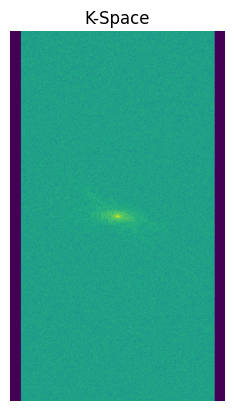

In [14]:
original_kspace, recon_img = im_manager.get_kspace_sample(70)
print(original_kspace.shape)
plt.imshow(np.log(np.abs(original_kspace) + 1e-9))
plt.title('K-Space')
plt.axis('off')
plt.show()

## Low-pass filtering

To simulate low-resolution images from high-resolution k-space data, a low-pass filter can be applied to remove high-frequency components before reconstructing the image. In k-space, high-frequency data correspond to fine spatial details, while low-frequency data primarily represent image contrast and overall structure. By cropping the k-space to retain only the central region and discarding peripheral high-frequency components, the effective resolution of the reconstructed image is reduced. This mimics the effect of imaging with a lower-field MRI system. After filtering, the modified k-space data can be transformed back into image space using an inverse Fourier transform, yielding a blurred, lower-resolution image. This method is commonly used in MRI simulations to study the effects of reduced resolution on diagnostic quality and to model imaging at different field strengths.

By using the ```FastMRIImageManager``` again, we can apply the low-pass filter and visualize its effect on both k-space and image domains.

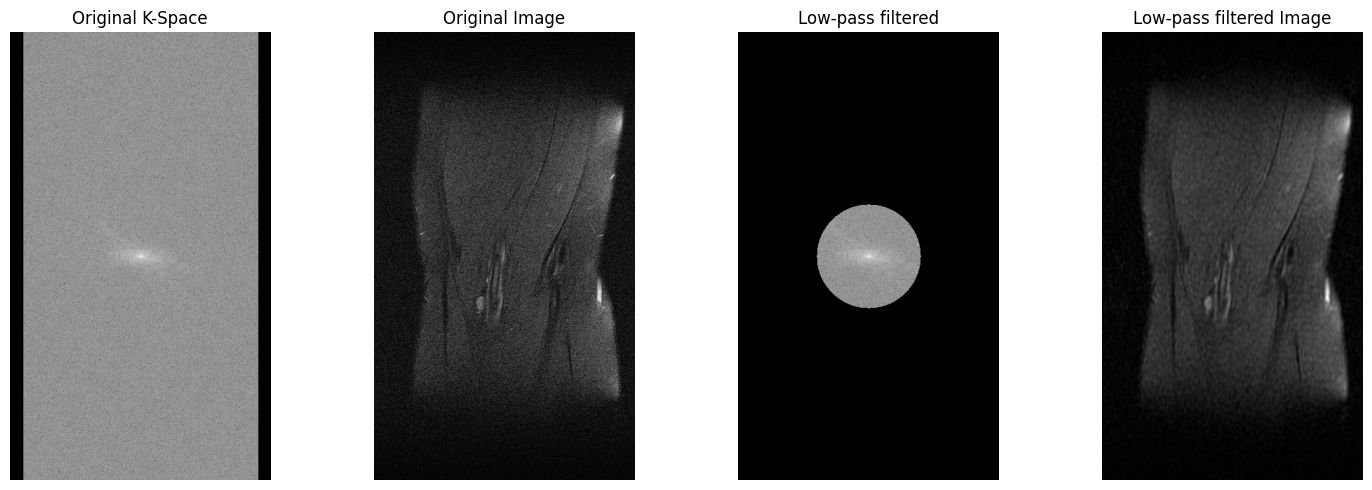

In [17]:
im_manager = FastMRIImageManager(data_path)
lr_kspace, lr_image = im_manager.apply_low_pass_filter(original_kspace, 20)
original_image = im_manager.ifft(original_kspace)
lr_image = im_manager.ifft(lr_kspace)

im_manager.display_images([
    (np.log(np.abs(original_kspace) + 1e-9), 'Original K-Space'),
    (original_image, 'Original Image'),
    (np.log(np.abs(lr_kspace) + 1e-9), 'Low-pass filtered'),
    (lr_image, 'Low-pass filtered Image'),
])

We can plot a patch from both images to have a better visualization of details loss.

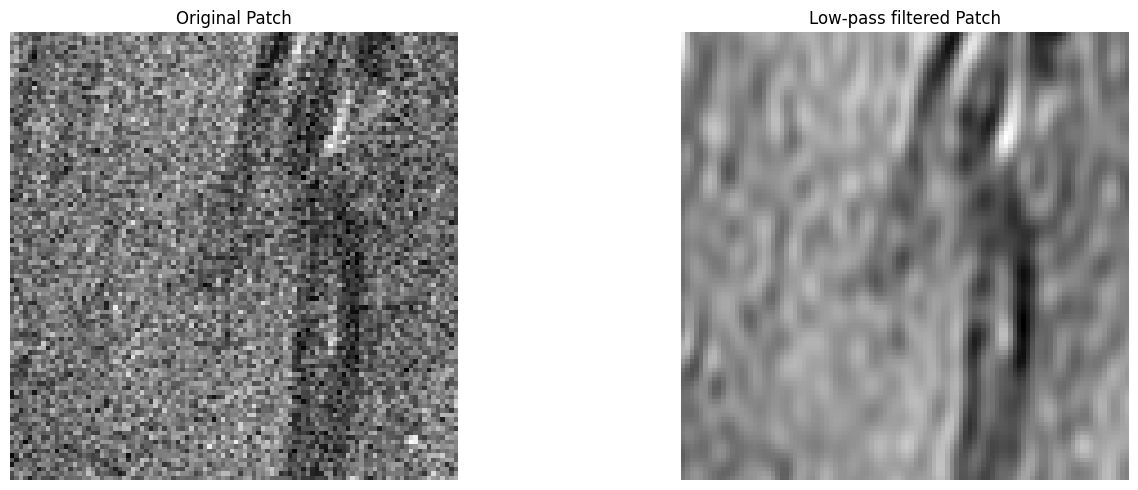

In [18]:
original_patch = im_manager.get_image_path(original_image, (original_image.shape[0]//2, original_image.shape[1]//2), (100, 100))
filtered_patch = im_manager.get_image_path(lr_image, (original_image.shape[0]//2, original_image.shape[1]//2), (100, 100))

im_manager.display_images([
    (original_patch, 'Original Patch'),
    (filtered_patch, 'Low-pass filtered Patch'),
])

## Simulation of a low Signal to Noie Ratio (SNR)

Although a number of complex factors determine image quality, signal-to-noise is approximately proportional to field strength. Therefore, the signal-to-noise ratio will be smaller in a lower-field scanner. Consequently, to maintain equivalent signal-to-noise, more signal averages and longer imaging times will be necessary in a lower-field scanner. Low-field MRI can thus benefit from super-resolution by scaling up images to enhance the acquisition of high-frequencies.

To build low-frequency dataset, noise should be added to k-spaces to lower the SNR of original images.

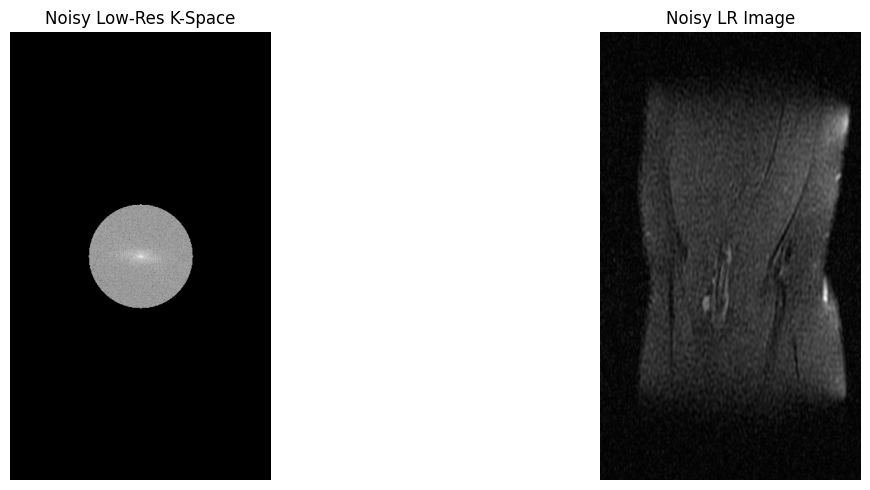

In [19]:
noisy_kspace, noisy_image = im_manager.add_gaussian_noise(lr_kspace, 15)

im_manager.display_images([
    (np.log(np.abs(noisy_kspace) + 1e-9), 'Noisy Low-Res K-Space'),
    (noisy_image, 'Noisy LR Image'),
])

## Full pre-processing pipeline

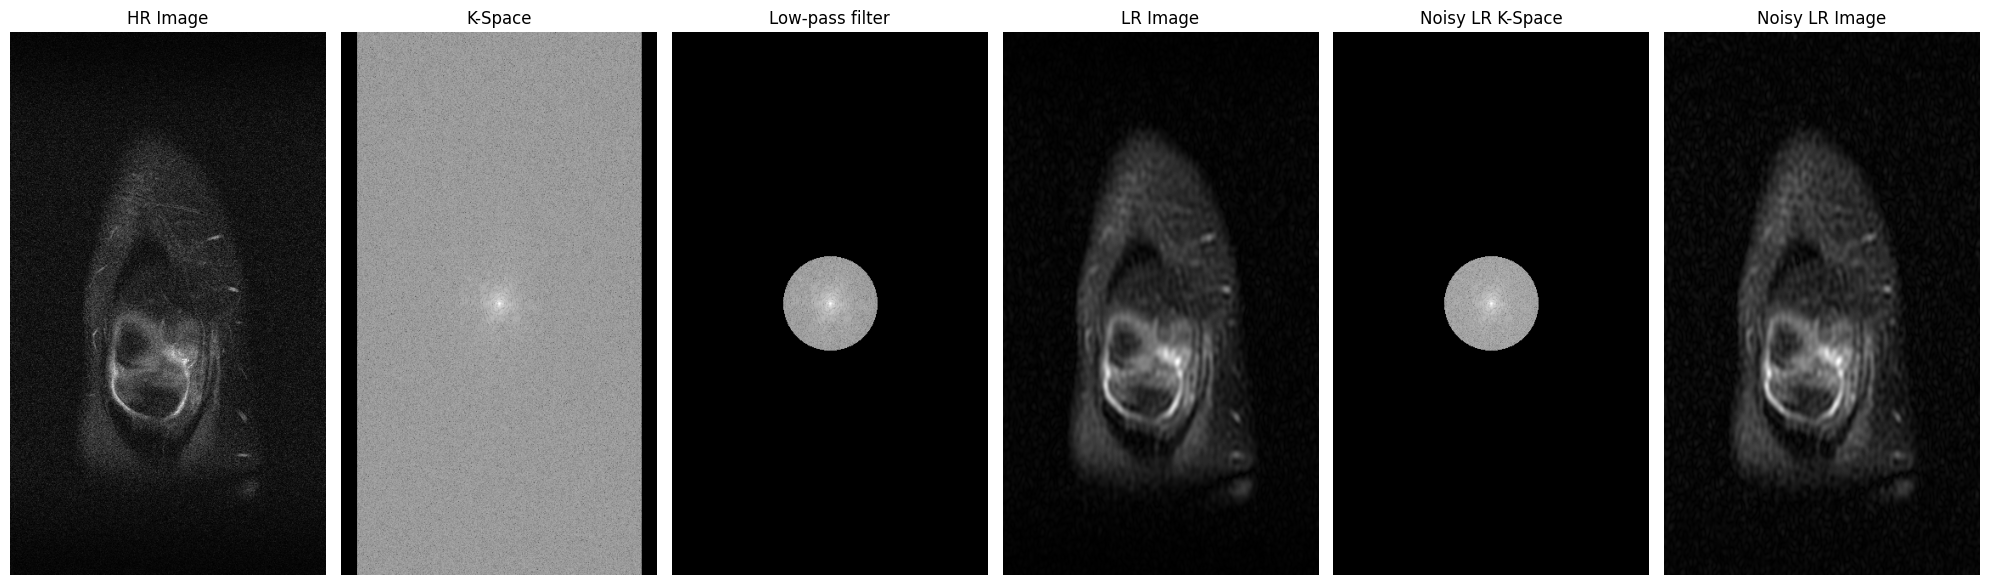

In [23]:
im_manager = FastMRIImageManager(data_path)
kspace, img = im_manager.get_kspace_sample(47)
sample = im_manager.run_full_preprocessing(kspace, 15, 15)

im_manager.display_images([
    (sample['hr_image'], 'HR Image'),
    (np.log(np.abs(sample["hr_kspace"]) + 1e-9), 'K-Space'),
    (np.log(np.abs(sample["lr_kspace"]) + 1e-9), 'Low-pass filter'),
    (sample["lr_image"], 'LR Image'),
    (np.log(np.abs(sample["noisy_lr_kspace"]) + 1e-9), 'Noisy LR K-Space'),
    (sample["noisy_lr_image"], 'Noisy LR Image'),
], figsize=(20, 8))

## Sources

Materials from this notebook used data from : 
- [Visualising MRI data in Python](https://medium.com/@nadavlevi/visualising-mri-data-in-python-fe010c4a1c54)
- [Boosting the signal‑to‑noise of low‑field MRI with deep learning image reconstruction](https://www.nature.com/articles/s41598-021-87482-7.pdf)

In [2]:
from src.data.sets.super_resolution import FastMRISuperResolutionDataset

dataset = FastMRISuperResolutionDataset(data_path)
sample = dataset[100]

In [3]:
lr_image = sample.image
hr_image = sample.target

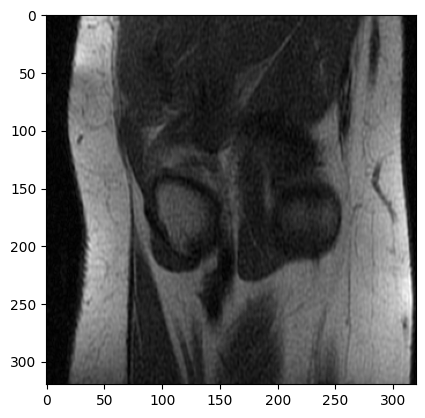

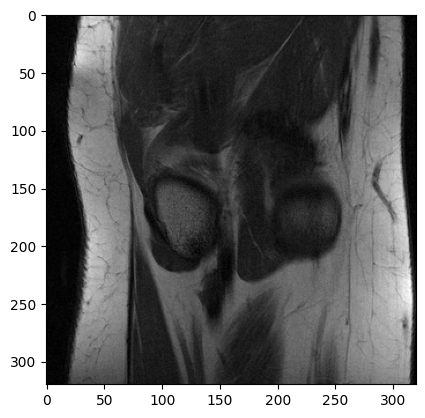

In [4]:
plt.imshow(lr_image[0], cmap='grey')
plt.show()

plt.imshow(hr_image[0], cmap='grey')
plt.show()